In [151]:
import numpy as np
import matplotlib.pyplot as plt

Идея реализации алгоритма состоит в следующем:
1. Сортируем массив $\mathcal{O}(n\log{}n)$.
2. Находим разницу между соседними элементами.  $\mathcal{O}(n)$. 
По алгоритму single-link в большие кластеры объединяются наиболее близкие кластеры (при этом расстояние между кластерами - минимальное расстояние между объектами, входящими в них). Поэтому, во-первых, в кластер входят только соседние элементы (не может быть точки, лежащей между другими точками, входящими в один кластер), а во-вторых, на каждом шаге можно проверять только соседние точки, потому что $n-1$ расстояние между ними гарантировано меньше других расстояний
3. Сортируем расстояния. Вводим дополнительный список, состоящий из пар соседних элемнтов, в порядке увеличения расстояния между ними $\mathcal{O}(n\log{}n)$.

По сути имеем последовательность пар элементов, которые на каждом шаге должны сливаться в один кластер. С помощью Python' их структур данных реализуем cлияние кластеров.


4. Обрабатываем пары элементов из дополнительно списка. Каждый элемент, который уже был обработан (т.е встречался в паре), является ключом в словаре. Ему соответсвует значение, являющееся множеством, содержащим все точки, которые принадлежат тому же кластеру. Так как всё в Python является ссылкой, то для разных ключей, значение соответсвующее им будет на самом деле единственны объектом, поэтому дополнительной памяти потребуется $\mathcal{O}(n)$

5. Если при обработке очередной пары оба элемента принадлежат неким кластерам, то эти кластеры сливаются. Это реализовано добавлением каждого элемента из меньшего кластера к большему, нужно это, чтобы умееьшить время: опарация set_A.add(elem) работает за $\mathcal{O}(1)$, тогда как set_A.union(set_B) - $\mathcal{O}(len(A) + len(B))$. Если использовать union в цикле, то в худшем случе это будет требовать $\mathcal{O}(n^2)$, используя же add мы сокращаем время работы до  $\mathcal{O}(n\log{}n)$.

6. Если один элемент в кластере, другой нет - добавляем второй в кластер к первому. Если оба не в кластере - создаём новый.

7. Вводится пороговое значение M - если расстояние стало слишком большим, заканчиваем кластеризацию. В результате в словаре как ключи лежат все обработанные точки, их значение - кластеры, которым они принадлежат. Итерируясь по значениям словаря получим все кластеры.

В пунктах 1-3 используются реализация сортирвоки из numpy. Во-первых, это очень быстро, так как библиотека написана на С, во-вторых, реализация merge-sort можно очень легко найти где угодно, поэтому здесь её непосредственный код не приводится.

Алгоритм single-link склонен выделять длинные тонкие кластеры - нити, это являестя его минусом в многомерных пространствах. На прямой же нас по сути и интересуют такие кластеры. Нас может не устроить работа алгоритма на данных, приведённых ниже (сначала точки расположены близко, начиная с 10 интервал между ними увеличивается на 2) - непонятно какой порог подобрать и что вообще здесь считать кластером. В работу алгоритма добавлен вывод на каждом шаге текущего словаря (ключ (точка) - элемента (кластер)) 

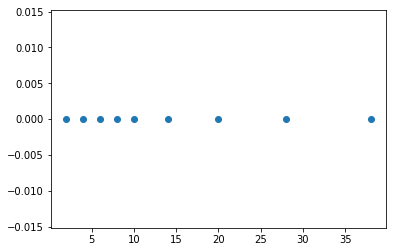

In [156]:
data = np.array(list({2, 4, 6, 8, 10,  14, 20, 28, 38}))
plt.scatter(data, np.zeros_like(data));

In [145]:
#1
indexes_sorted = np.argsort(data, kind='mergesort')
data_sorted = data[indexes_sorted]

#2
data_sorted_diff = np.diff(data_sorted)
pair_dist_args_sorted = np.argsort(data_sorted_diff, kind='mergesort')

#3
all_pairs = np.repeat(indexes_sorted, 2)[1:-1].reshape(data.shape[0]-1, 2)
sorted_pairs = all_pairs[pair_dist_args_sorted]
pair_dist_sorted = data_sorted_diff[pair_dist_args_sorted]


In [146]:
def make_compile_cluster(cluster_smaller, cluster_bigger):
    list_change = list()
    for elem in cluster_smaller:
        cluster_bigger.add(elem)
        list_change.append(elem)
    return list_change

elems_in_clusters = dict()

M = 15 #constant to stop union
#4
for i, pair in enumerate(sorted_pairs):
    if pair_dist_sorted[i] > M:
        break
    
    cl_1 = elems_in_clusters.get(pair[0])
    cl_2 = elems_in_clusters.get(pair[1])

    #5
    if cl_1 and cl_2:
        if len(cl_1) > len(cl_2):
            to_change = make_compile_cluster(cl_2, cl_1)
            cl_2 = cl_1
        else:
            to_change = make_compile_cluster(cl_1, cl_2)
            cl_1 = cl_2
        
        for elem in to_change:
            elems_in_clusters[elem] = cl_1
    
    #6
    elif cl_1:
        cl_1.add(pair[1])
        elems_in_clusters[pair[1]] = cl_1
    
    elif cl_2:
        cl_2.add(pair[0])
        elems_in_clusters[pair[0]] = cl_2
        
    else:
        new_cluster = set(pair)
        elems_in_clusters[pair[0]] = new_cluster
        elems_in_clusters[pair[1]] = new_cluster
    
    print(elems_in_clusters)
    print('---------------------')


{0: {0, 1}, 1: {0, 1}}
---------------------
{0: {0, 1, 2}, 1: {0, 1, 2}, 2: {0, 1, 2}}
---------------------
{0: {0, 1, 2, 4}, 1: {0, 1, 2, 4}, 2: {0, 1, 2, 4}, 4: {0, 1, 2, 4}}
---------------------
{0: {0, 1, 2, 4, 5}, 1: {0, 1, 2, 4, 5}, 2: {0, 1, 2, 4, 5}, 4: {0, 1, 2, 4, 5}, 5: {0, 1, 2, 4, 5}}
---------------------
{0: {0, 1, 2, 4, 5, 6}, 1: {0, 1, 2, 4, 5, 6}, 2: {0, 1, 2, 4, 5, 6}, 4: {0, 1, 2, 4, 5, 6}, 5: {0, 1, 2, 4, 5, 6}, 6: {0, 1, 2, 4, 5, 6}}
---------------------
{0: {0, 1, 2, 4, 5, 6, 7}, 1: {0, 1, 2, 4, 5, 6, 7}, 2: {0, 1, 2, 4, 5, 6, 7}, 4: {0, 1, 2, 4, 5, 6, 7}, 5: {0, 1, 2, 4, 5, 6, 7}, 6: {0, 1, 2, 4, 5, 6, 7}, 7: {0, 1, 2, 4, 5, 6, 7}}
---------------------
{0: {0, 1, 2, 4, 5, 6, 7, 8}, 1: {0, 1, 2, 4, 5, 6, 7, 8}, 2: {0, 1, 2, 4, 5, 6, 7, 8}, 4: {0, 1, 2, 4, 5, 6, 7, 8}, 5: {0, 1, 2, 4, 5, 6, 7, 8}, 6: {0, 1, 2, 4, 5, 6, 7, 8}, 7: {0, 1, 2, 4, 5, 6, 7, 8}, 8: {0, 1, 2, 4, 5, 6, 7, 8}}
---------------------
{0: {0, 1, 2, 3, 4, 5, 6, 7, 8}, 1: {0, 1, 2, 3, 4, 5, 